# Analyzing Udemy Course Reviews Using Natural Language Processing

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import shuffle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Getting the dataset

In [2]:
dataset=pd.read_csv('Udemy.csv',encoding='latin')

## Number of rows and columns in the dataset

In [3]:
dataset.shape

(914, 2)

## Printing the first 10 rows of dataset

In [4]:
dataset.head(10)

,Udemy_Reviews,Star
0,must add some mathematical intuition to get be...,1
1,It was the most resourceful and informative on...,1
2,Some of the codes are already out of the date ...,1
3,You have made a very short (1 min) video of a ...,1
4,Worst course on Udemy with no real life exampl...,1
5,The assumptions of linear regression equation ...,1
6,I thought this course was to be good. The revi...,1
7,Do not waste your money. Some lectures are AWF...,1
8,doubt sessions are the worst.even after two we...,1
9,Overview of ML and sklearn API calls (and some...,1


## Printing the information about dataset

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 2 columns):
Udemy_Reviews    893 non-null object
Star             914 non-null int64
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


## Description of dataset

In [6]:
dataset.describe()

,Star
count,914.000000
mean,3.078775
std,1.999542
min,1.000000
25%,1.000000
50%,5.000000
75%,5.000000
max,5.000000


## Checking for any null values

In [7]:
dataset.isnull().sum()
#21 reviews found empty

Udemy_Reviews    21
Star              0
dtype: int64

## Dropping the empty rows

In [8]:
dataset=dataset.dropna()

## Reset index (0,1,.....) after dropping the rows with null values 

In [9]:
dataset=dataset.reset_index(drop=True)

## Size of new dataset formed

In [10]:
dataset.shape

(893, 2)

## First and last 10 rows of the new dataset

In [11]:
dataset.head(10)

,Udemy_Reviews,Star
0,must add some mathematical intuition to get be...,1
1,It was the most resourceful and informative on...,1
2,Some of the codes are already out of the date ...,1
3,You have made a very short (1 min) video of a ...,1
4,Worst course on Udemy with no real life exampl...,1
5,The assumptions of linear regression equation ...,1
6,I thought this course was to be good. The revi...,1
7,Do not waste your money. Some lectures are AWF...,1
8,doubt sessions are the worst.even after two we...,1
9,Overview of ML and sklearn API calls (and some...,1


In [12]:
dataset.tail(10)

,Udemy_Reviews,Star
883,The course is too good and explains everything...,5
884,Extremely useful for my master's research. 11/10,5
885,it is perfect if you do not have background ab...,5
886,Nice explanation. Servers the need for picking...,5
887,Great Course!,5
888,"Amazing course , very helpfull and easy for be...",5
889,"It's really great, the explanation is very det...",5
890,"Very Well structured content, I am really enjo...",5
891,The best Machine Learning course for beginners,5
892,Great systematic and intuitive way of teaching...,5


## Adding a column in the dataset, representing the length of each review

In [13]:
dataset['Review_Length'] = dataset['Udemy_Reviews'].apply(len)


In [14]:
dataset.head(10)

,Udemy_Reviews,Star,Review_Length
0,must add some mathematical intuition to get be...,1,82
1,It was the most resourceful and informative on...,1,158
2,Some of the codes are already out of the date ...,1,401
3,You have made a very short (1 min) video of a ...,1,992
4,Worst course on Udemy with no real life exampl...,1,83
5,The assumptions of linear regression equation ...,1,121
6,I thought this course was to be good. The revi...,1,488
7,Do not waste your money. Some lectures are AWF...,1,251
8,doubt sessions are the worst.even after two we...,1,148
9,Overview of ML and sklearn API calls (and some...,1,2995


## Counting the number of reviews in 1 star and 5 star categories

5    472
1    421
Name: Star, dtype: int64


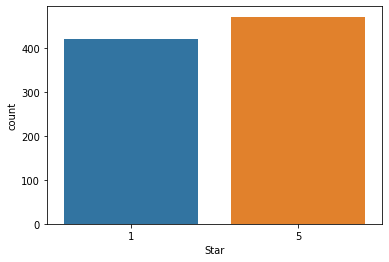

In [15]:
target_numbers = dataset.Star.value_counts()
print(target_numbers)
sns.countplot(x='Star',data=dataset)

In [16]:
print("Percentage of reviews with 1 star:",round(target_numbers[1]*100/len(dataset),2))
print("Percentage of reviews with 5 star:",round(target_numbers[5]*100/len(dataset),2))

Percentage of reviews with 1 star: 47.14
Percentage of reviews with 5 star: 52.86


## Histogram representing frequency vs length of reviews

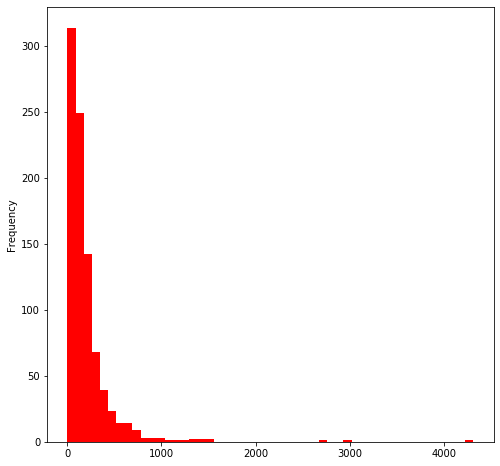

In [17]:
plt.figure(figsize=(8,8))
dataset['Review_Length'].plot(bins=50,kind='hist',color='red')

## Studying the length of reviews

In [18]:
dataset.Review_Length.describe()

count     893.000000
mean      200.410974
std       274.577740
min         3.000000
25%        67.000000
50%       134.000000
75%       239.000000
max      4310.000000
Name: Review_Length, dtype: float64

## Review with the longest length

In [19]:
dataset[dataset['Review_Length']==4310]['Udemy_Reviews'].iloc[0]

"I am just at 19th lecture of this 303 video course and understood precisely what is coming my way and going to return it right away. Had already planned next 2 weeks for this course after going through the excellent syllabus but here are the things which one must know before taking this course.There is a huge difference between knowledge and understanding. Knowledge can be acquired by google results as well but people need to build understanding of a subject in order to write a code and make any kind of analysis.When we are talking about Data science and Analytics, the understanding part is the only important thing as this is hugely complex work and no single pattern can be followed for different use cases. You just write a piece of code and that works doesn't make anyone understand the subject unless they know whats the meaning of those steps.1) All the trainer is doing is writing a piece of code in the way it is supposed to and that works. Just the way someone types by looking at th

## Review with the shortest length

In [20]:
dataset[dataset['Review_Length']==3]['Udemy_Reviews'].iloc[0]

'Bad'

## Separate histograms for both classes ( 1 star and 5 star reviews)

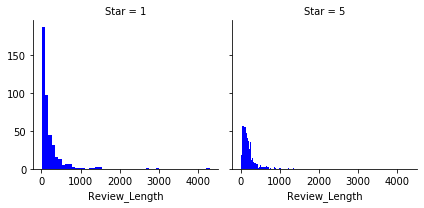

In [21]:
#plt.figure(figsize=(20,20))
g = sns.FacetGrid(data=dataset, col='Star', col_wrap=2)
g.map(plt.hist, 'Review_Length', bins = 50, color = 'blue')

## Cleaning of the reviews 

In [22]:
corpus=[]
for i in range(0,len(dataset)):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Udemy_Reviews'][i]) 
    #review = [char for char in review if char not in string.punctuation]
    review = ''.join(review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))] 
    
    review = ' '.join(review)  
    corpus.append(review)
    
    

In [23]:
corpus

['must add mathemat intuit get better understand algorithm',
 'resourc inform onlin cours machin learn howev concept behind xgboost explain detail',
 'code alreadi date teacher care even post issu q part besid question post q part answer ta answer run full code noth spend one dollar cours produc experi terribl aw',
 'made short min video small ugli place africa call tour africa emphasis peopl live africa throughout world everi one take cours descript africa mind dont know pay advertis incorrect wrong imag africa mayb afro phobia complet wrong relat content cours urg remov african know african like contin resum one small street africa video min african need posit thing give hope imag give digniti front world video reiter whole opposit thank understand becom posit ambassador belov contin world udemi student note today one',
 'worst cours udemi real life exampl data visual techniqu',
 'assumpt linear regress equat explain includ classif algorithm',
 'thought cours good review misl instruc

## 1) Feature Extraction using Count Vectorizer (Bag of Words Model)

In [24]:
vectorizer=CountVectorizer()
numbers=vectorizer.fit_transform(corpus).toarray()
print(vectorizer.get_feature_names())

['abaut', 'abl', 'absolut', 'abund', 'abus', 'academ', 'accept', 'access', 'accompani', 'accord', 'account', 'accur', 'acquaint', 'acquir', 'across', 'act', 'action', 'actual', 'ad', 'adaboost', 'adapt', 'add', 'addit', 'address', 'adem', 'adequ', 'adjust', 'admir', 'admiss', 'adopt', 'advanc', 'advertis', 'affair', 'affect', 'affin', 'afford', 'affraid', 'afraid', 'africa', 'african', 'afro', 'afterward', 'age', 'ago', 'ah', 'ahead', 'ai', 'aim', 'algebra', 'algo', 'algorithim', 'algorithm', 'allegedli', 'allow', 'almost', 'alon', 'along', 'alot', 'alphabet', 'alreadi', 'also', 'alta', 'altern', 'although', 'alumno', 'alway', 'amaount', 'amateur', 'amaz', 'amazingli', 'amazon', 'ambarishg', 'ambassador', 'amend', 'amount', 'an', 'anaconda', 'analog', 'analogu', 'analys', 'analysi', 'analyt', 'analyz', 'ancient', 'andrew', 'angri', 'anim', 'ann', 'announc', 'annoy', 'anonym', 'anoth', 'answer', 'anybodi', 'anymor', 'anyon', 'anyth', 'anytim', 'anywher', 'apart', 'api', 'appear', 'appet

In [25]:
count_of_words=pd.DataFrame(numbers,columns=vectorizer.get_feature_names())
count_of_words

,abaut,abl,absolut,abund,abus,academ,accept,access,accompani,accord,...,xgboost,ye,yeah,year,yet,youtub,yup,zero,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Defining the independent and dependent variables

In [26]:
X=numbers
y=dataset['Star'].values

## Forming the training and test set

In [27]:
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=0)

train_x,train_y = shuffle(train_x, train_y)

## Finding out the optimal value of alpha in MultinomialNB

In [28]:
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(train_x,train_y)
    y_pred=sub_classifier.predict(test_x)
    score = sub_classifier.score(test_x, test_y)
    print("Alpha: {}, Score : {}".format(alpha,score))

E:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Alpha: 0.0, Score : 0.8044692737430168
Alpha: 0.1, Score : 0.8547486033519553
Alpha: 0.2, Score : 0.8547486033519553
Alpha: 0.30000000000000004, Score : 0.8603351955307262
Alpha: 0.4, Score : 0.8659217877094972
Alpha: 0.5, Score : 0.8715083798882681
Alpha: 0.6000000000000001, Score : 0.8603351955307262
Alpha: 0.7000000000000001, Score : 0.8603351955307262
Alpha: 0.8, Score : 0.8547486033519553
Alpha: 0.9, Score : 0.8547486033519553


## Applying the classifier with alpha as 0.5

In [29]:
classifier=MultinomialNB(alpha=0.5)
classifier.fit(train_x,train_y)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

## Testing the performance of the trained model on the test set

In [30]:
y_pred=classifier.predict(test_x)

In [31]:
cm=confusion_matrix(test_y,y_pred)
cm

array([[66, 19],
       [ 4, 90]], dtype=int64)

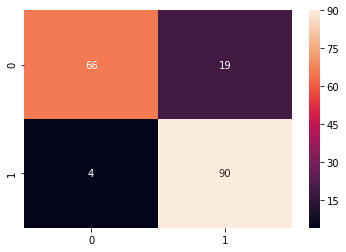

In [32]:
sns.heatmap(cm,annot=True)

In [33]:
print('Accuracy Score:',round(classifier.score(test_x,test_y)*100,2))

Accuracy Score: 87.15


## Analyzing our trained model on two sample reviews

In [34]:
sample1=['Amazing Course! Thank you Udemy!!']
numbers_sample=vectorizer.transform(sample1)
pred=classifier.predict(numbers_sample)
print("Rating is:",pred)

Rating is: [5]


In [35]:
sample1=['Very bad and outdated course!!']
numbers_sample=vectorizer.transform(sample1)
pred=classifier.predict(numbers_sample)
print("Rating is:",pred)

Rating is: [1]


## 2) Feature Extraction using TF-IDF followed by similar steps as above

In [36]:
tfidf_dataset=TfidfTransformer().fit_transform(numbers)
print(tfidf_dataset.shape)

(893, 2012)


In [37]:
tfidf_dataset

<893x2012 sparse matrix of type '<class 'numpy.float64'>'
	with 13694 stored elements in Compressed Sparse Row format>

In [38]:
print(tfidf_dataset[:,:]) #gives score/weight of each of the single words in our matrix.

  (0, 1869)	0.24501290483057353
  (0, 1140)	0.40063469957013065
  (0, 1070)	0.3589138973598454
  (0, 928)	0.29831744375269686
  (0, 753)	0.27579964117750255
  (0, 194)	0.37380469620739204
  (0, 51)	0.3009522940599639
  (0, 21)	0.5052527632001269
  (1, 2002)	0.4344766819010673
  (1, 1479)	0.38749010737435907
  (1, 1212)	0.3795059136301388
  (1, 1044)	0.17643331710063964
  (1, 991)	0.14721287997891846
  (1, 892)	0.30759226982974786
  (1, 837)	0.3220698810241305
  (1, 633)	0.1969462769918315
  (1, 469)	0.2689165754533206
  (1, 400)	0.10400022786146393
  (1, 350)	0.2257179862154174
  (1, 184)	0.3050339549679664
  (2, 1771)	0.19812679717045156
  (2, 1759)	0.18407329999949537
  (2, 1748)	0.2221514092671769
  (2, 1655)	0.16814582273513845
  (2, 1509)	0.1763391023967887
  :	:
  (892, 1992)	0.14753997506038763
  (892, 1954)	0.14944332082102454
  (892, 1930)	0.13263798771449367
  (892, 1914)	0.22084901727142106
  (892, 1798)	0.22474859091085977
  (892, 1773)	0.2456487942351778
  (892, 1758)	0.16

In [39]:
X=tfidf_dataset
y=dataset['Star'].values

In [40]:
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=0)

train_x,train_y = shuffle(train_x, train_y)


for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(train_x,train_y)
    y_pred=sub_classifier.predict(test_x)
    score = sub_classifier.score(test_x, test_y)
    print("Alpha: {}, Score : {}".format(alpha,score))

Alpha: 0.0, Score : 0.8379888268156425
Alpha: 0.1, Score : 0.9050279329608939
Alpha: 0.2, Score : 0.9050279329608939
Alpha: 0.30000000000000004, Score : 0.9106145251396648
Alpha: 0.4, Score : 0.9050279329608939
Alpha: 0.5, Score : 0.8938547486033519
Alpha: 0.6000000000000001, Score : 0.888268156424581
Alpha: 0.7000000000000001, Score : 0.8770949720670391
Alpha: 0.8, Score : 0.8715083798882681
Alpha: 0.9, Score : 0.8547486033519553


E:\Anaconda\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [41]:
classifier=MultinomialNB(alpha=0.3)
classifier.fit(train_x,train_y)

MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)

In [42]:
y_pred=classifier.predict(test_x)

In [43]:
cm=confusion_matrix(test_y,y_pred)
cm

array([[73, 12],
       [ 4, 90]], dtype=int64)

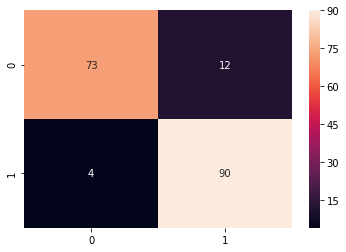

In [44]:
sns.heatmap(cm,annot=True)

In [45]:
print('Accuracy Score:',round(classifier.score(test_x,test_y)*100,2))

Accuracy Score: 91.06


In [46]:
sample1=['Less explanation about topics.']
numbers_sample=vectorizer.transform(sample1)
tfidf_dataset=TfidfTransformer().fit_transform(numbers_sample)
pred=classifier.predict(tfidf_dataset)
print("Rating is:",pred)

Rating is: [1]


In [47]:
sample1=["I've already completed the half of the course, and it's above my expectations, I've learned a lot so far."]
numbers_sample=vectorizer.transform(sample1)
tfidf_dataset=TfidfTransformer().fit_transform(numbers_sample)
pred=classifier.predict(tfidf_dataset)
print("Rating is:",pred)

Rating is: [5]


# End of Project.